### Performance Metrics

## Success Indicators

You have now been asked to discover what key performance indicators (KPIs) will determine the success of the new design? Use at least completion rate, time spent on each step and error rates. Add any KPIs you might find relevant.

- **Completion Rate:** The proportion of users who reach the final ‘confirm’ step.
- **Time Spent on Each Step:** The average duration users spend on each step.
- **Error Rates:** If there’s a step where users go back to a previous step, it may indicate confusion or an error. You should consider moving from a later step to an earlier one as an error.

## Redesign Outcome

Based on the chosen KPIs, how does the new design’s performance compare to the old one?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
# import reusable functions from utils directory
import sys
sys.path.append('../../utils')
import functions

In [3]:
combined_cleaned_df = pd.read_csv('../../data/raw/combined_cleaned_data.csv')
combined_cleaned_df.head()

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


In [4]:
print(combined_cleaned_df['process_step'].unique())

['step_3' 'step_2' 'step_1' 'start' 'confirm']


In [5]:
combined_cleaned_df['date_time'] = pd.to_datetime(combined_cleaned_df['date_time'], errors='coerce')

# check if any dates couldn't be converted (i.e., they are NaT)
inconsistent_dates = combined_cleaned_df['date_time'].isna().sum()

# if inconsistent_dates > 0, then there are invalid or mismatched date formats
if inconsistent_dates > 0:
    print(f'There are {inconsistent_dates} inconsistent or invalid date formats in the column.')
else:
    print('All dates in the column have the same format.')

print(combined_cleaned_df[['date_time']].head())

All dates in the column have the same format.
            date_time
0 2017-04-17 15:27:07
1 2017-04-17 15:26:51
2 2017-04-17 15:19:22
3 2017-04-17 15:19:13
4 2017-04-17 15:18:04


In [6]:
functions.inspect_dataframe(combined_cleaned_df)

Check the shape (rows, columns):
(744641, 5)

Column names:
Index(['client_id', 'visitor_id', 'visit_id', 'process_step', 'date_time'], dtype='object')

Data types:
client_id                int64
visitor_id              object
visit_id                object
process_step            object
date_time       datetime64[ns]
dtype: object

Missing values:
client_id       0
visitor_id      0
visit_id        0
process_step    0
date_time       0
dtype: int64


In [7]:
# make a copy
kpi_df = combined_cleaned_df.copy()

# drop columns
kpi_df = kpi_df.drop(columns=['visitor_id', 'visit_id'])

In [8]:
# change the naming of the steps to numeric values to ensure order
replacement_dict_steps = {
    'start' : 0,
    'step_1' : 1,
    'step_2' : 2,
    'step_3' : 3,
    'confirm' : 4
}

kpi_df['process_step'] = kpi_df['process_step'].map(replacement_dict_steps)

# **Completion Rate**

In [9]:
def find_completion_rate(df):    
    clients_finished = df[df['process_step'] == 4] # filter rows where process_step is 'Finish'
    total_unique_clients = df['client_id'].nunique()
    unique_clients_finished = clients_finished['client_id'].nunique() # find unique client ids that finished
    print(f'Clients who finished the process: {unique_clients_finished} out ouf {total_unique_clients}.')

find_completion_rate(kpi_df)

Clients who finished the process: 81145 out ouf 120157.


**To-do's**:
- [ ] calculate percentage
- [ ] visual representation?

# **Time spent on each step**

In [10]:
# sort df by client_id and date_time
kpi_df = kpi_df.sort_values(by=['client_id', 'date_time'])

# calculate time difference between steps per client
kpi_df['time_diff'] = kpi_df.groupby('client_id')['date_time'].diff()

# drop first row per client (contains no information)
kpi_df = kpi_df.dropna(subset=['time_diff'])
display(kpi_df)

,client_id,process_step,date_time,time_diff
283822,169,1,2017-04-12 20:19:45,0 days 00:00:09
283821,169,2,2017-04-12 20:20:31,0 days 00:00:46
283820,169,3,2017-04-12 20:22:05,0 days 00:01:34
283819,169,4,2017-04-12 20:23:09,0 days 00:01:04
620397,336,0,2017-06-01 07:42:43,0 days 00:15:48
...,...,...,...,...
640076,9999875,1,2017-06-01 22:40:08,0 days 00:00:07
640075,9999875,1,2017-06-01 22:41:28,0 days 00:01:20
640074,9999875,2,2017-06-01 22:41:47,0 days 00:00:19
640073,9999875,3,2017-06-01 22:44:58,0 days 00:03:11


In [11]:
# calculate average time spent on each step
avg_time_per_step = kpi_df.groupby('process_step')['time_diff'].mean()

# convert to total seconds
avg_time_in_seconds = avg_time_per_step.dt.total_seconds()

# round up to the nearest second to remove decimals
avg_time_in_seconds_rounded = np.ceil(avg_time_in_seconds).astype(int)

# convert back to timedelta
avg_time_per_step_rounded = pd.to_timedelta(avg_time_in_seconds_rounded, unit='s')

# re-map process_step index for readability
# avg_time_per_step_rounded.index = avg_time_per_step_rounded.index.map({0: 'Start', 1: 'Step 1', 2: 'Step 2', 3: 'Step 3', 4: 'Finish'})

print('Average time spent on each step:\n')
print(avg_time_per_step_rounded)

Average time spent on each step:

process_step
0   2 days 21:02:52
1   0 days 00:23:31
2   0 days 00:01:05
3   0 days 00:09:49
4   0 days 17:49:27
Name: time_diff, dtype: timedelta64[ns]


**To-do's**:
- [ ] calculate percentage
- [x] visual representation?
- [ ] Convert to seconds?

# **Error Rates**
_(Constanza's code)_

In [12]:
df = pd.read_csv('../../data/raw/combined_cleaned_data.csv')
df

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...
744636,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:46:10
744637,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:45:29
744638,9668240,388766751_9038881013,922267647_3096648104_968866,step_1,2017-05-24 18:44:51
744639,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:44:34


In [13]:
# drop columns
df = df.drop(columns=['visitor_id', 'visit_id'])

# change steps to numeric values to ensure order
replacement_dict_steps = {
    'start' : 0,
    'step_1' : 1,
    'step_2' : 2,
    'step_3' : 3,
    'confirm' : 4
}

df['process_step'] = df['process_step'].map(replacement_dict_steps)

In [14]:
# sort df by client_id and date_time
df = df.sort_values(by=['client_id', 'date_time'])

In [15]:
# Detect backward steps (errors) for all clients
df['backward_step'] = df.groupby('client_id')['process_step'].diff() < 0

# Count the number of unique clients who experienced at least one error
clients_with_errors = df[df['backward_step']]['client_id'].nunique()

# Count the total number of errors for each client
errors_per_client = df[df['backward_step']].groupby('client_id').size()

# Total number of errors across all clients
total_errors = df['backward_step'].sum()

# Output results
print(f'Number of clients with at least one error: {clients_with_errors}')
print('Errors per client:')
print(errors_per_client)
print(f'Total number of errors across all clients: {total_errors}')

Number of clients with at least one error: 42424
Errors per client:
client_id
722        2
805        2
832        1
1028       2
1197       1
          ..
9998460    1
9998980    1
9999150    1
9999729    2
9999768    3
Length: 42424, dtype: int64
Total number of errors across all clients: 74980


In [16]:
# add column 'error_count'
df['error_count'] = df['client_id'].map(errors_per_client).fillna(0).astype(int)

In [17]:
# # Crear un DataFrame con los resultados
# results_df = errors_per_client.reset_index()
# results_df.columns = ['client_id', 'number_of_errors']

# # Guardar el DataFrame en un archivo CSV
# results_df.to_csv('errors_per_client.csv', index=False)

# # Mensaje de confirmación
# print('El archivo 'errors_per_client.csv' se ha guardado correctamente.')

# **Redesign Outcome**
Based on the chosen KPIs, how does the new design’s performance compare to the old one?

For the project requirements and instructions for today’s tasks in full, please refer to the project brief. However, in order to keep on track you may refer to the daily goals outlined below:

By the end of day, we recommend you have:

Reviewed KPI and Metrics material.
Discovered what key performance indicators (KPIs) will determine the success of the new design
Use at least completion rate, time spent on each step and error rates. Add any KPIs you might find relevant.
Evaluated how the new design’s performance compare to the old one, given the chosen KPIs (completion rate, time spent on each step and error rates).

Steps:
- [x] import `merged_final_demo_final_experiment_clients_df`
- [x] merge with `kpi_df`
- [x] add column of errors per client
- [x] clean data if needed

In [18]:
merged_final_demo_final_experiment_clients_df = pd.read_csv('../../data/clean/merged_final_demo_final_experiment_clients_df.csv')

In [19]:
merged_df = pd.merge(kpi_df, merged_final_demo_final_experiment_clients_df, on='client_id', how='outer')

In [20]:
# functions.inspect_dataframe(df)

In [21]:
# match datatypes in dfs before merging on `date_time` column to prevent errors
merged_df['date_time'] = pd.to_datetime(merged_df['date_time'], errors='coerce')
df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')

In [22]:
# select columns to merge
df_selected = df[['client_id', 'date_time', 'backward_step', 'error_count']]
merged_kpi_df = pd.merge(merged_df, df_selected, on=['client_id', 'date_time'], how='left')

In [23]:
# merged_kpi_df: 5682251 rows, 15 columns - before matching date_time
# merged_kpi_df: 631469 rows × 15 columns - after matching date and time

In [24]:
merged_kpi_df.rename(columns={'backward_step': 'stepped_back'}, inplace=True)

In [25]:
merged_kpi_df.drop(columns=['client_tenure_months', 'num_accounts', 'calls_last_6_months', 'logons_last_6_months', 'balance'], inplace=True)

In [26]:
functions.floats_to_ints(merged_kpi_df, 'process_step')
functions.floats_to_ints(merged_kpi_df, 'client_tenure_years')
functions.floats_to_ints(merged_kpi_df, 'client_age')
functions.floats_to_ints(merged_kpi_df, 'error_count')

,client_id,process_step,date_time,time_diff,client_tenure_years,client_age,gender,variation,stepped_back,error_count
0,169,1,2017-04-12 20:19:45,0 days 00:00:09,21,47,Male,Unknown,False,0
1,169,2,2017-04-12 20:20:31,0 days 00:00:46,21,47,Male,Unknown,False,0
2,169,3,2017-04-12 20:22:05,0 days 00:01:34,21,47,Male,Unknown,False,0
3,169,4,2017-04-12 20:23:09,0 days 00:01:04,21,47,Male,Unknown,False,0
4,336,0,2017-06-01 07:42:43,0 days 00:15:48,<NA>,<NA>,NaN,NaN,False,0
...,...,...,...,...,...,...,...,...,...,...
631464,9999875,1,2017-06-01 22:40:08,0 days 00:00:07,<NA>,<NA>,NaN,NaN,False,0
631465,9999875,1,2017-06-01 22:41:28,0 days 00:01:20,<NA>,<NA>,NaN,NaN,False,0
631466,9999875,2,2017-06-01 22:41:47,0 days 00:00:19,<NA>,<NA>,NaN,NaN,False,0
631467,9999875,3,2017-06-01 22:44:58,0 days 00:03:11,<NA>,<NA>,NaN,NaN,False,0


In [27]:
# convert NaN values in 'variation' to 'Unknown'
merged_kpi_df['variation'] = merged_kpi_df['variation'].fillna('Unknown')

In [28]:
functions.handle_unique_gender_values(merged_kpi_df)

['Male' nan 'Unspecified' 'Female']


,client_id,process_step,date_time,time_diff,client_tenure_years,client_age,gender,variation,stepped_back,error_count
0,169,1,2017-04-12 20:19:45,0 days 00:00:09,21,47,Male,Unknown,False,0
1,169,2,2017-04-12 20:20:31,0 days 00:00:46,21,47,Male,Unknown,False,0
2,169,3,2017-04-12 20:22:05,0 days 00:01:34,21,47,Male,Unknown,False,0
3,169,4,2017-04-12 20:23:09,0 days 00:01:04,21,47,Male,Unknown,False,0
4,336,0,2017-06-01 07:42:43,0 days 00:15:48,<NA>,<NA>,Unspecified,Unknown,False,0
...,...,...,...,...,...,...,...,...,...,...
631464,9999875,1,2017-06-01 22:40:08,0 days 00:00:07,<NA>,<NA>,Unspecified,Unknown,False,0
631465,9999875,1,2017-06-01 22:41:28,0 days 00:01:20,<NA>,<NA>,Unspecified,Unknown,False,0
631466,9999875,2,2017-06-01 22:41:47,0 days 00:00:19,<NA>,<NA>,Unspecified,Unknown,False,0
631467,9999875,3,2017-06-01 22:44:58,0 days 00:03:11,<NA>,<NA>,Unspecified,Unknown,False,0


In [29]:
functions.inspect_dataframe(merged_kpi_df)

Check the shape (rows, columns):
(631469, 10)

Column names:
Index(['client_id', 'process_step', 'date_time', 'time_diff',
       'client_tenure_years', 'client_age', 'gender', 'variation',
       'stepped_back', 'error_count'],
      dtype='object')

Data types:
client_id                        int64
process_step                     Int64
date_time               datetime64[ns]
time_diff              timedelta64[ns]
client_tenure_years              Int64
client_age                       Int64
gender                          object
variation                       object
stepped_back                    object
error_count                      Int64
dtype: object

Missing values:
client_id                   0
process_step             5059
date_time                5059
time_diff                5059
client_tenure_years    251772
client_age             251772
gender                      0
variation                   0
stepped_back             5059
error_count              5059
dtype: int64


In [30]:
functions.check_unique_and_empty(merged_kpi_df)
merged_kpi_df

Summary of Unique and Empty Values:

                     Unique value count  Empty value count
Column                                                    
client_id                        116435                  0
process_step                          5               5059
date_time                        539786               5059
time_diff                         35861               5059
client_tenure_years                  54             251772
client_age                           84             251772
gender                                3                  0
variation                             3                  0
stepped_back                          2               5059
error_count                          24               5059

--------------------------------------------------



,client_id,process_step,date_time,time_diff,client_tenure_years,client_age,gender,variation,stepped_back,error_count
0,169,1,2017-04-12 20:19:45,0 days 00:00:09,21,47,Male,Unknown,False,0
1,169,2,2017-04-12 20:20:31,0 days 00:00:46,21,47,Male,Unknown,False,0
2,169,3,2017-04-12 20:22:05,0 days 00:01:34,21,47,Male,Unknown,False,0
3,169,4,2017-04-12 20:23:09,0 days 00:01:04,21,47,Male,Unknown,False,0
4,336,0,2017-06-01 07:42:43,0 days 00:15:48,<NA>,<NA>,Unspecified,Unknown,False,0
...,...,...,...,...,...,...,...,...,...,...
631464,9999875,1,2017-06-01 22:40:08,0 days 00:00:07,<NA>,<NA>,Unspecified,Unknown,False,0
631465,9999875,1,2017-06-01 22:41:28,0 days 00:01:20,<NA>,<NA>,Unspecified,Unknown,False,0
631466,9999875,2,2017-06-01 22:41:47,0 days 00:00:19,<NA>,<NA>,Unspecified,Unknown,False,0
631467,9999875,3,2017-06-01 22:44:58,0 days 00:03:11,<NA>,<NA>,Unspecified,Unknown,False,0


In [31]:
print(merged_kpi_df['variation'].unique())

['Unknown' 'Test' 'Control']


### Evaluate how the new design’s performance compare to the old one, given the chosen KPIs (completion rate, time spent on each step and error rates).



In [32]:
# split in dfs, for Variation Control and Variation Test
df_test_kpi = merged_kpi_df[merged_kpi_df['variation'] == 'Test']
df_control_kpi = merged_kpi_df[merged_kpi_df['variation'] == 'Control']

In [33]:
# drop empty rows
df_test_kpi = df_test_kpi.dropna()
df_control_kpi = df_control_kpi.dropna()

## Completion Rates

In [34]:
print('\nCompletion rate for Control:')
functions.find_completion_rate(df_control_kpi)


Completion rate for Control:
Clients who finished the process: 15407 out ouf 21274.


(15407, 21274, 0.7242173545172511)

In [35]:
print('\nCompletion rate for Test:')
functions.find_completion_rate(df_test_kpi)


Completion rate for Test:
Clients who finished the process: 18620 out ouf 25563.


(18620, 25563, 0.7283965105817001)

## Time spent on each step

In [36]:
functions.calculate_time_per_step(df_test_kpi)

Average time spent on each step:
 process_step
0   3 days 05:16:07
1   0 days 00:40:57
2   0 days 00:01:52
3   0 days 00:12:20
4   1 days 03:56:57
Name: time_diff, dtype: timedelta64[ns]


process_step
0   3 days 05:16:07
1   0 days 00:40:57
2   0 days 00:01:52
3   0 days 00:12:20
4   1 days 03:56:57
Name: time_diff, dtype: timedelta64[ns]

In [37]:
functions.calculate_time_per_step(df_control_kpi)

Average time spent on each step:
 process_step
0   4 days 01:23:08
1   0 days 01:00:59
2   0 days 00:00:40
3   0 days 00:07:44
4   0 days 17:50:07
Name: time_diff, dtype: timedelta64[ns]


process_step
0   4 days 01:23:08
1   0 days 01:00:59
2   0 days 00:00:40
3   0 days 00:07:44
4   0 days 17:50:07
Name: time_diff, dtype: timedelta64[ns]

## Error Rate

In [38]:
functions.find_error_rate(df_test_kpi)

Errors per client: client_id
1346       2
1516       4
1643       1
1755       1
1836       3
          ..
9994764    6
9995295    4
9998156    1
9999150    1
9999729    2
Length: 10189, dtype: int64
Total number of errors across all clients: 19250


(10189,
 client_id
 1346       2
 1516       4
 1643       1
 1755       1
 1836       3
           ..
 9994764    6
 9995295    4
 9998156    1
 9999150    1
 9999729    2
 Length: 10189, dtype: int64,
 19250)

In [39]:
functions.find_error_rate(df_control_kpi)

Errors per client: client_id
1028       2
1197       1
3647       1
5354       1
7020       4
          ..
9995265    1
9996404    1
9997391    2
9997470    3
9998346    1
Length: 8074, dtype: int64
Total number of errors across all clients: 13522


(8074,
 client_id
 1028       2
 1197       1
 3647       1
 5354       1
 7020       4
           ..
 9995265    1
 9996404    1
 9997391    2
 9997470    3
 9998346    1
 Length: 8074, dtype: int64,
 13522)

# Storing values

In [40]:
# store the results for test df
test_unique_finished, test_total_clients, test_completion_rate = functions.find_completion_rate(df_test_kpi)
test_avg_time_per_step = functions.calculate_time_per_step(df_test_kpi)
test_clients_with_errors, test_errors_per_client, test_total_errors = functions.find_error_rate(df_test_kpi)

# store the results for control df
control_unique_finished, control_total_clients, control_completion_rate = functions.find_completion_rate(df_control_kpi)
control_avg_time_per_step = functions.calculate_time_per_step(df_control_kpi)
control_clients_with_errors, control_errors_per_client, control_total_errors = functions.find_error_rate(df_control_kpi)

Clients who finished the process: 18620 out ouf 25563.
Average time spent on each step:
 process_step
0   3 days 05:16:07
1   0 days 00:40:57
2   0 days 00:01:52
3   0 days 00:12:20
4   1 days 03:56:57
Name: time_diff, dtype: timedelta64[ns]
Errors per client: client_id
1346       2
1516       4
1643       1
1755       1
1836       3
          ..
9994764    6
9995295    4
9998156    1
9999150    1
9999729    2
Length: 10189, dtype: int64
Total number of errors across all clients: 19250
Clients who finished the process: 15407 out ouf 21274.
Average time spent on each step:
 process_step
0   4 days 01:23:08
1   0 days 01:00:59
2   0 days 00:00:40
3   0 days 00:07:44
4   0 days 17:50:07
Name: time_diff, dtype: timedelta64[ns]
Errors per client: client_id
1028       2
1197       1
3647       1
5354       1
7020       4
          ..
9995265    1
9996404    1
9997391    2
9997470    3
9998346    1
Length: 8074, dtype: int64
Total number of errors across all clients: 13522


## **Testing Plots**

In [41]:
def plot_completion_rate(test_completion_rate, control_completion_rate):
    completion_rate_data = {
        'Version': ['Test', 'Control'],
        'Completion Rate': [test_completion_rate, control_completion_rate]
    }
    completion_rate_df = pd.DataFrame(completion_rate_data)
    
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x='Version', y='Completion Rate', data=completion_rate_df)
    
    # Manually set colors for each bar
    ax.patches[0].set_facecolor('lightblue')
    ax.patches[1].set_facecolor('salmon')
    
    plt.title('Completion Rate (Test vs Control)', fontsize=16)
    plt.ylabel('Completion Rate (%)')
    plt.show()

In [42]:
def plot_avg_time_per_step(test_avg_time_per_step, control_avg_time_per_step):
    test_avg_time_seconds = test_avg_time_per_step.dt.total_seconds().round() # convert to seconds
    control_avg_time_seconds = control_avg_time_per_step.dt.total_seconds().round()

    time_data = {
        'Process Step': test_avg_time_per_step.index,
        'Test': test_avg_time_seconds.values,
        'Control': control_avg_time_seconds.values
    }
    time_df = pd.DataFrame(time_data)
    
    time_df.set_index('Process Step').plot(kind='bar', figsize=(10, 6), width=0.8, color=['lightblue', 'salmon'])
    plt.title('Average Time per Step (Test vs Control)', fontsize=16)
    plt.ylabel('Average Time (in seconds)')
    plt.xlabel('Step within the process')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [43]:
def plot_error_rate(test_clients_with_errors, control_clients_with_errors, test_total_errors, control_total_errors):
    # number of clients with errors
    clients_error_data = {
        'Version': ['Test', 'Control'],
        'Clients': [test_clients_with_errors, control_clients_with_errors]
    }
    clients_error_df = pd.DataFrame(clients_error_data)
    
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x='Version', y='Clients', data=clients_error_df)
    
    ax.patches[0].set_facecolor('cadetblue')
    ax.patches[1].set_facecolor('lightcoral')
    
    plt.title('Client Error Count (Test vs Control)', fontsize=16)
    plt.show()

    # total errors comparison
    total_errors_data = {
        'Version': ['Test', 'Control'],
        'Total Errors': [test_total_errors, control_total_errors]
    }
    total_errors_df = pd.DataFrame(total_errors_data)
    
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x='Version', y='Total Errors', data=total_errors_df)
    
    ax.patches[0].set_facecolor('cadetblue')
    ax.patches[1].set_facecolor('lightcoral')
    
    plt.title('Total Error Count (Test vs Control)', fontsize=16)
    plt.show()

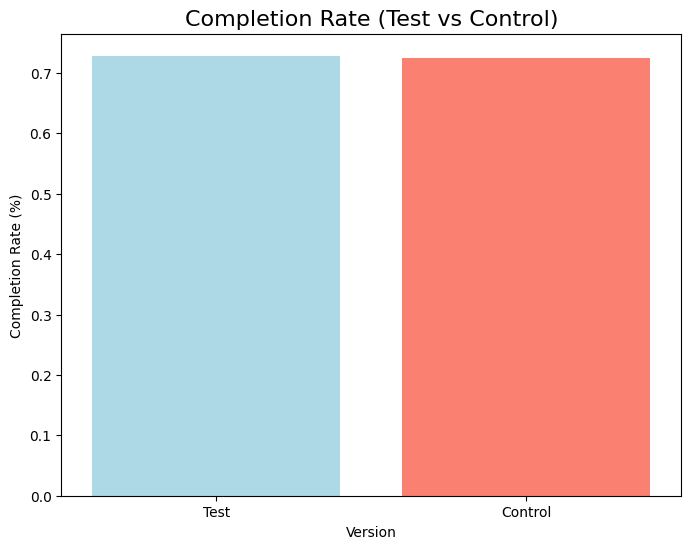

In [44]:
plot_completion_rate(test_completion_rate, control_completion_rate)

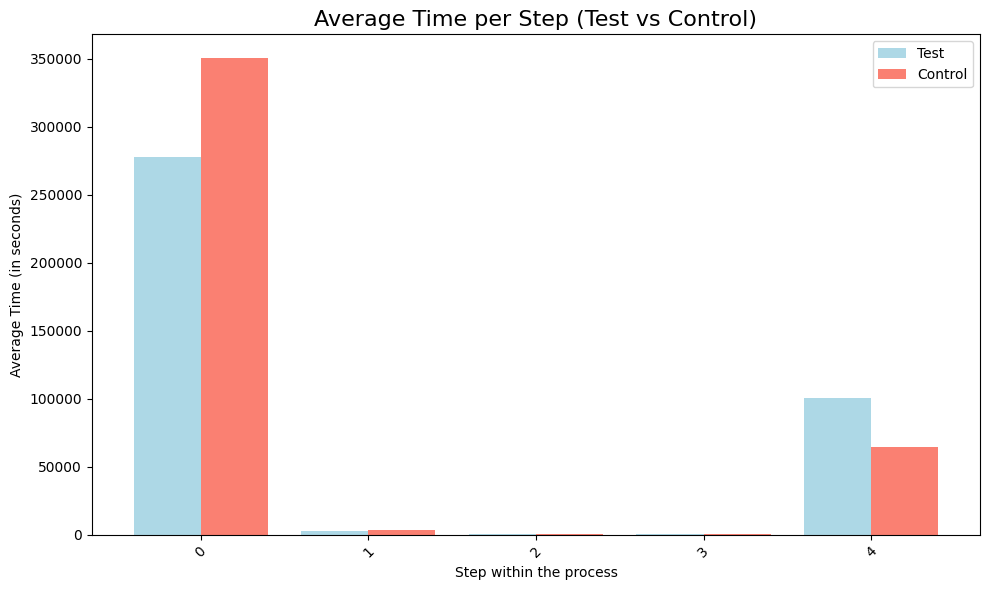

In [45]:
plot_avg_time_per_step(test_avg_time_per_step, control_avg_time_per_step)

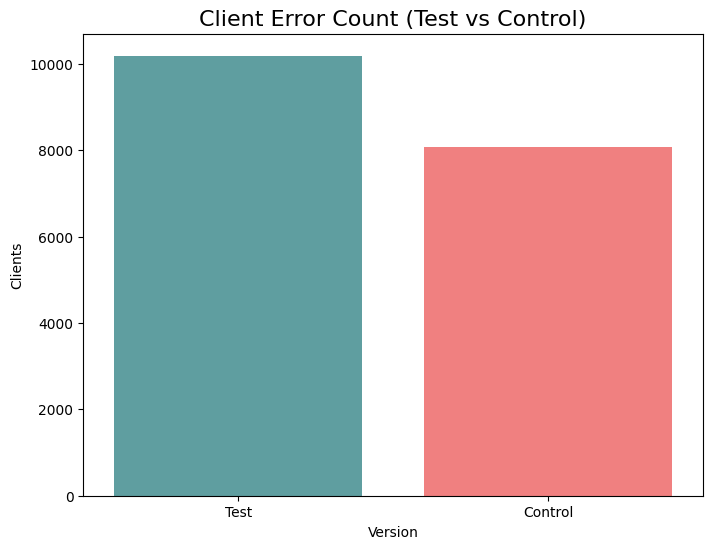

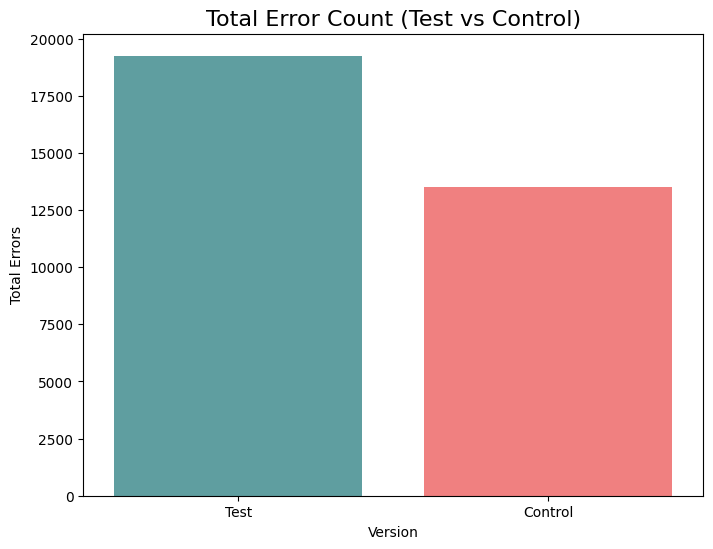

In [46]:
plot_error_rate(test_clients_with_errors, control_clients_with_errors, test_total_errors, control_total_errors)

## **More Plots!**

In [47]:
# **Completion Rate Comparison - Pie Chart**
def plot_completion_rate_pie(test_completion_rate, control_completion_rate):
    completion_rate_data = {
        'Version': ['Test', 'Control'],
        'Completion Rate': [test_completion_rate, control_completion_rate]
    }
    completion_rate_df = pd.DataFrame(completion_rate_data)
    
    # Pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(completion_rate_df['Completion Rate'], labels=completion_rate_df['Version'], autopct='%1.1f%%', startangle=90, colors=['lightblue', 'salmon'])
    plt.title('Completion Rate (Test vs Control)')
    plt.show()

In [48]:
# **Average Time per Step - Boxplot**
def plot_avg_time_per_step_boxplot(test_avg_time_per_step, control_avg_time_per_step):
    # Convert to seconds for easy comparison
    test_avg_time_seconds = test_avg_time_per_step.dt.total_seconds().round()  # Use .dt.total_seconds() for Series
    control_avg_time_seconds = control_avg_time_per_step.dt.total_seconds().round()  # Use .dt.total_seconds() for Series
    
    # Create DataFrame for boxplot
    time_df = pd.DataFrame({
        'Process Step': ['Step 1', 'Step 2', 'Step 3', 'Step 4', 'Step 5'],
        'Test': test_avg_time_seconds,
        'Control': control_avg_time_seconds
    })

    # Reshape the data for the boxplot
    time_df = time_df.melt(id_vars='Process Step', value_vars=['Test', 'Control'], var_name='Version', value_name='Time (in seconds)')

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Process Step', y='Time (in seconds)', hue='Version', data=time_df)
    plt.title('Average Time per Step (Test vs Control) (Boxplot)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [49]:
# **Error Rate - Heatmap of Errors per Client**

def plot_error_heatmap(test_errors_per_client, control_errors_per_client):
    error_data = {
        'Test': test_errors_per_client,
        'Control': control_errors_per_client
    }
    error_df = pd.DataFrame(error_data).T  # transpose to get rows as groups
    
    plt.figure(figsize=(8, 6))
    # Use 'f' for floating-point numbers, or use '.2f' for two decimal places
    sns.heatmap(error_df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True)
    plt.title('Error Count Heatmap (Test vs Control)')
    plt.show()


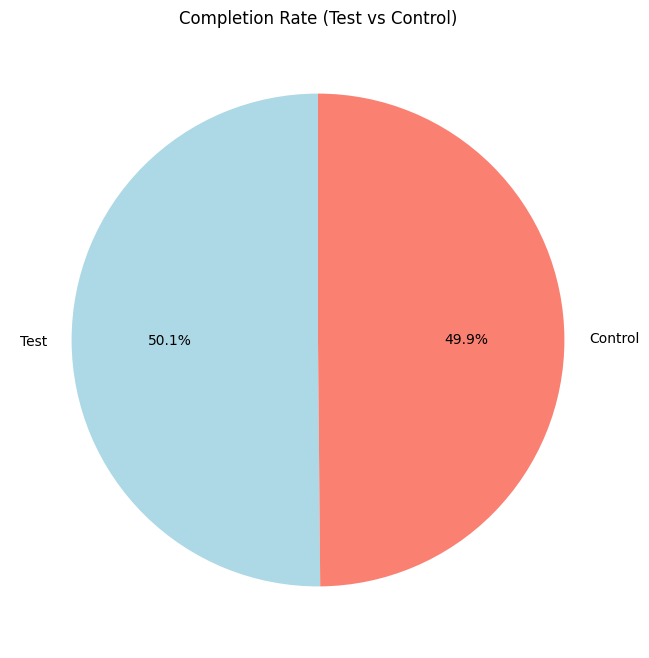

In [50]:
# plot the results
plot_completion_rate_pie(test_completion_rate, control_completion_rate)

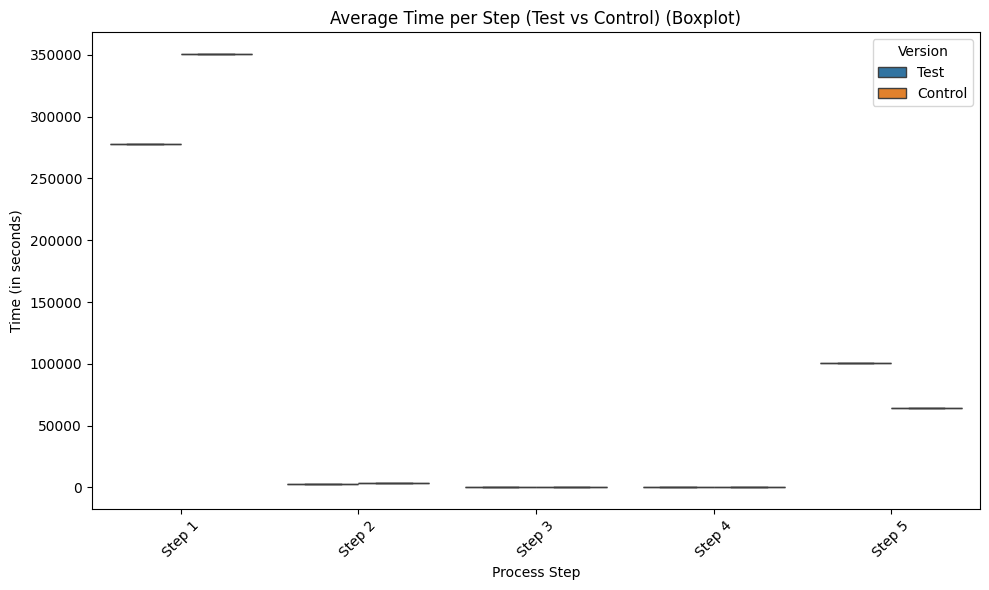

In [51]:
plot_avg_time_per_step_boxplot(test_avg_time_per_step, control_avg_time_per_step)

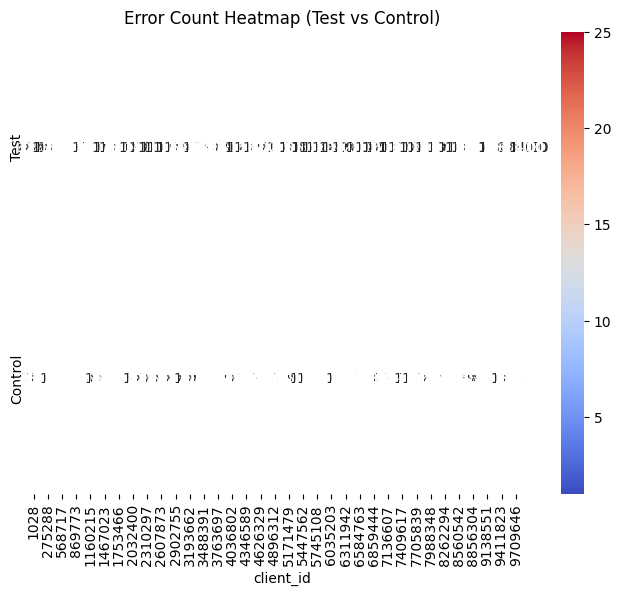

In [53]:
plot_error_heatmap(test_errors_per_client, control_errors_per_client)